# Visualization of the results of the chunking experiments

In [4]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

FIGURES_PATH = Path("figures/")

sns.set_theme(
    style="whitegrid",
    context="paper",
    font="DejaVu Serif",
    font_scale=1.3,
    palette="pastel",
)

DPI = 300
FIGSIZE_S = (8, 5)
FIGSIZE_L = (15, 5)

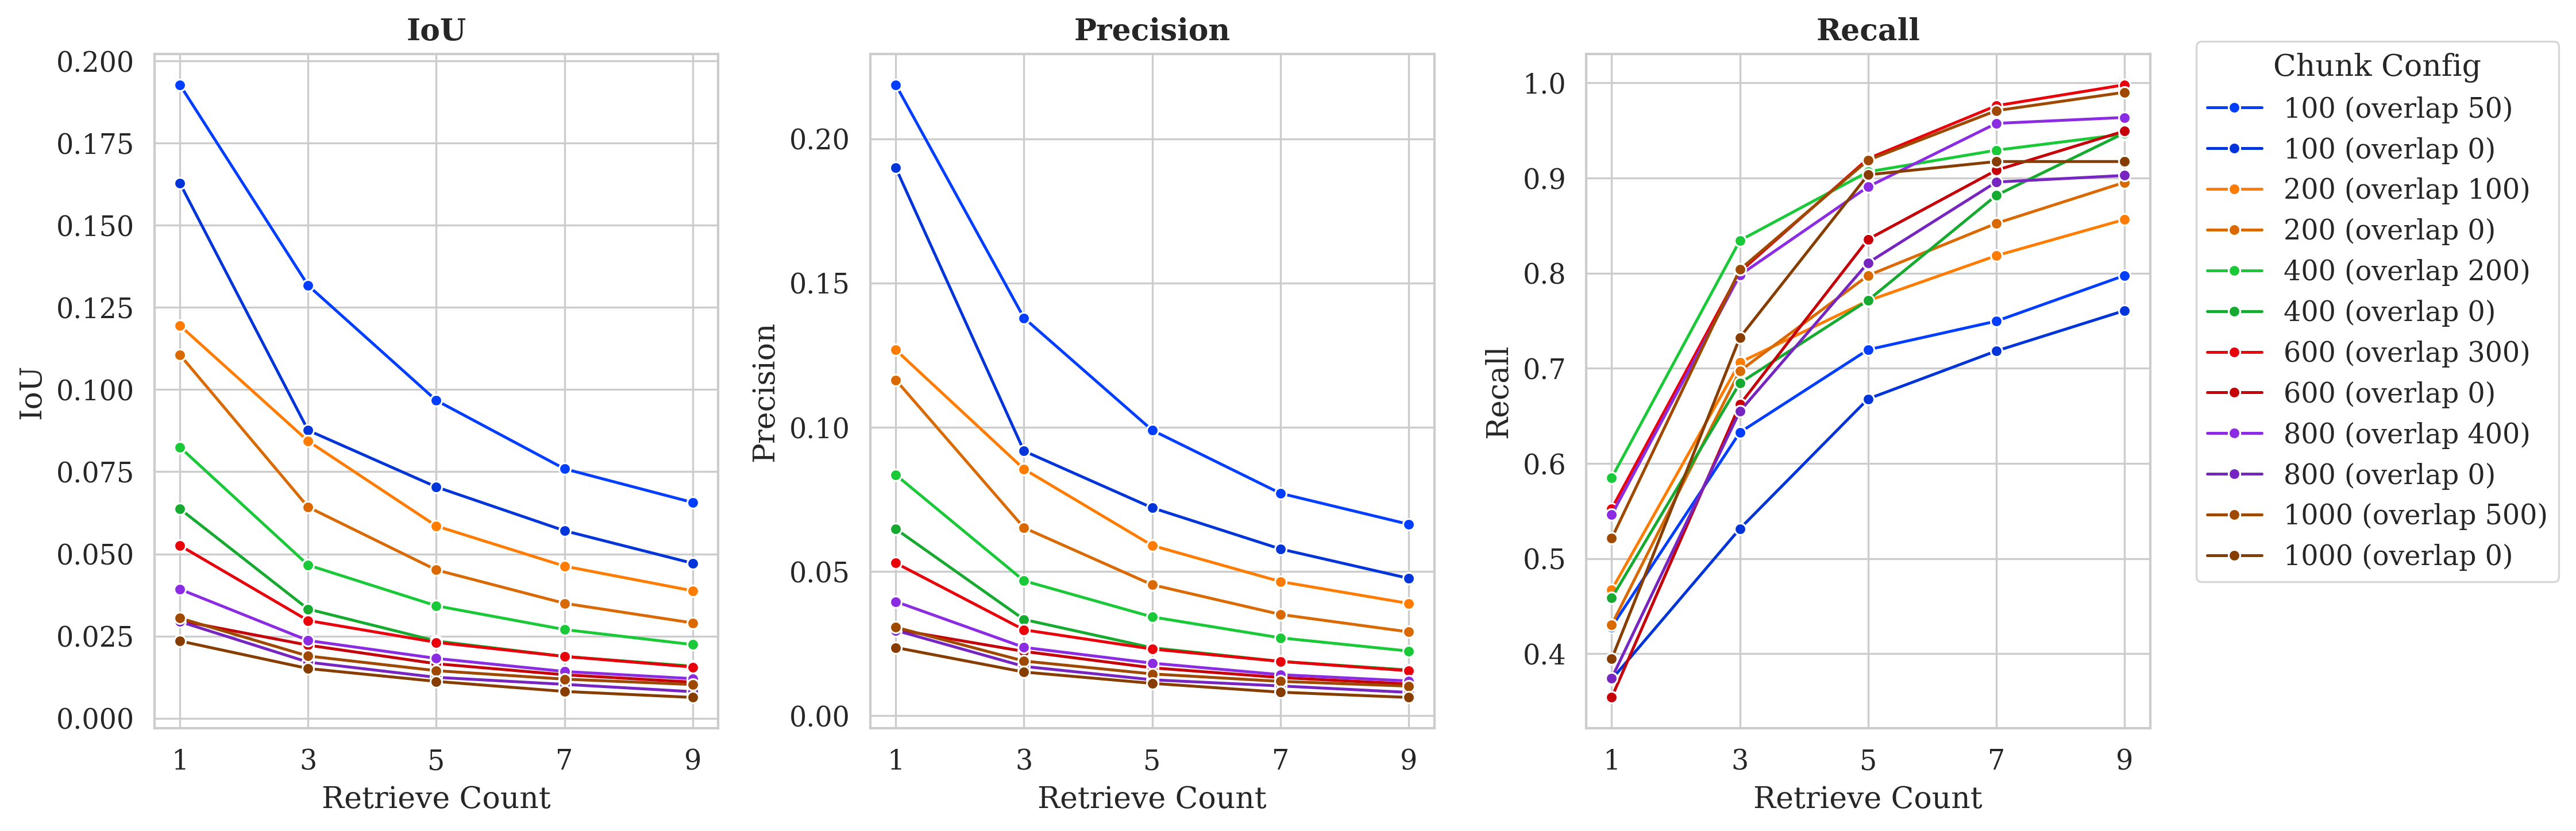

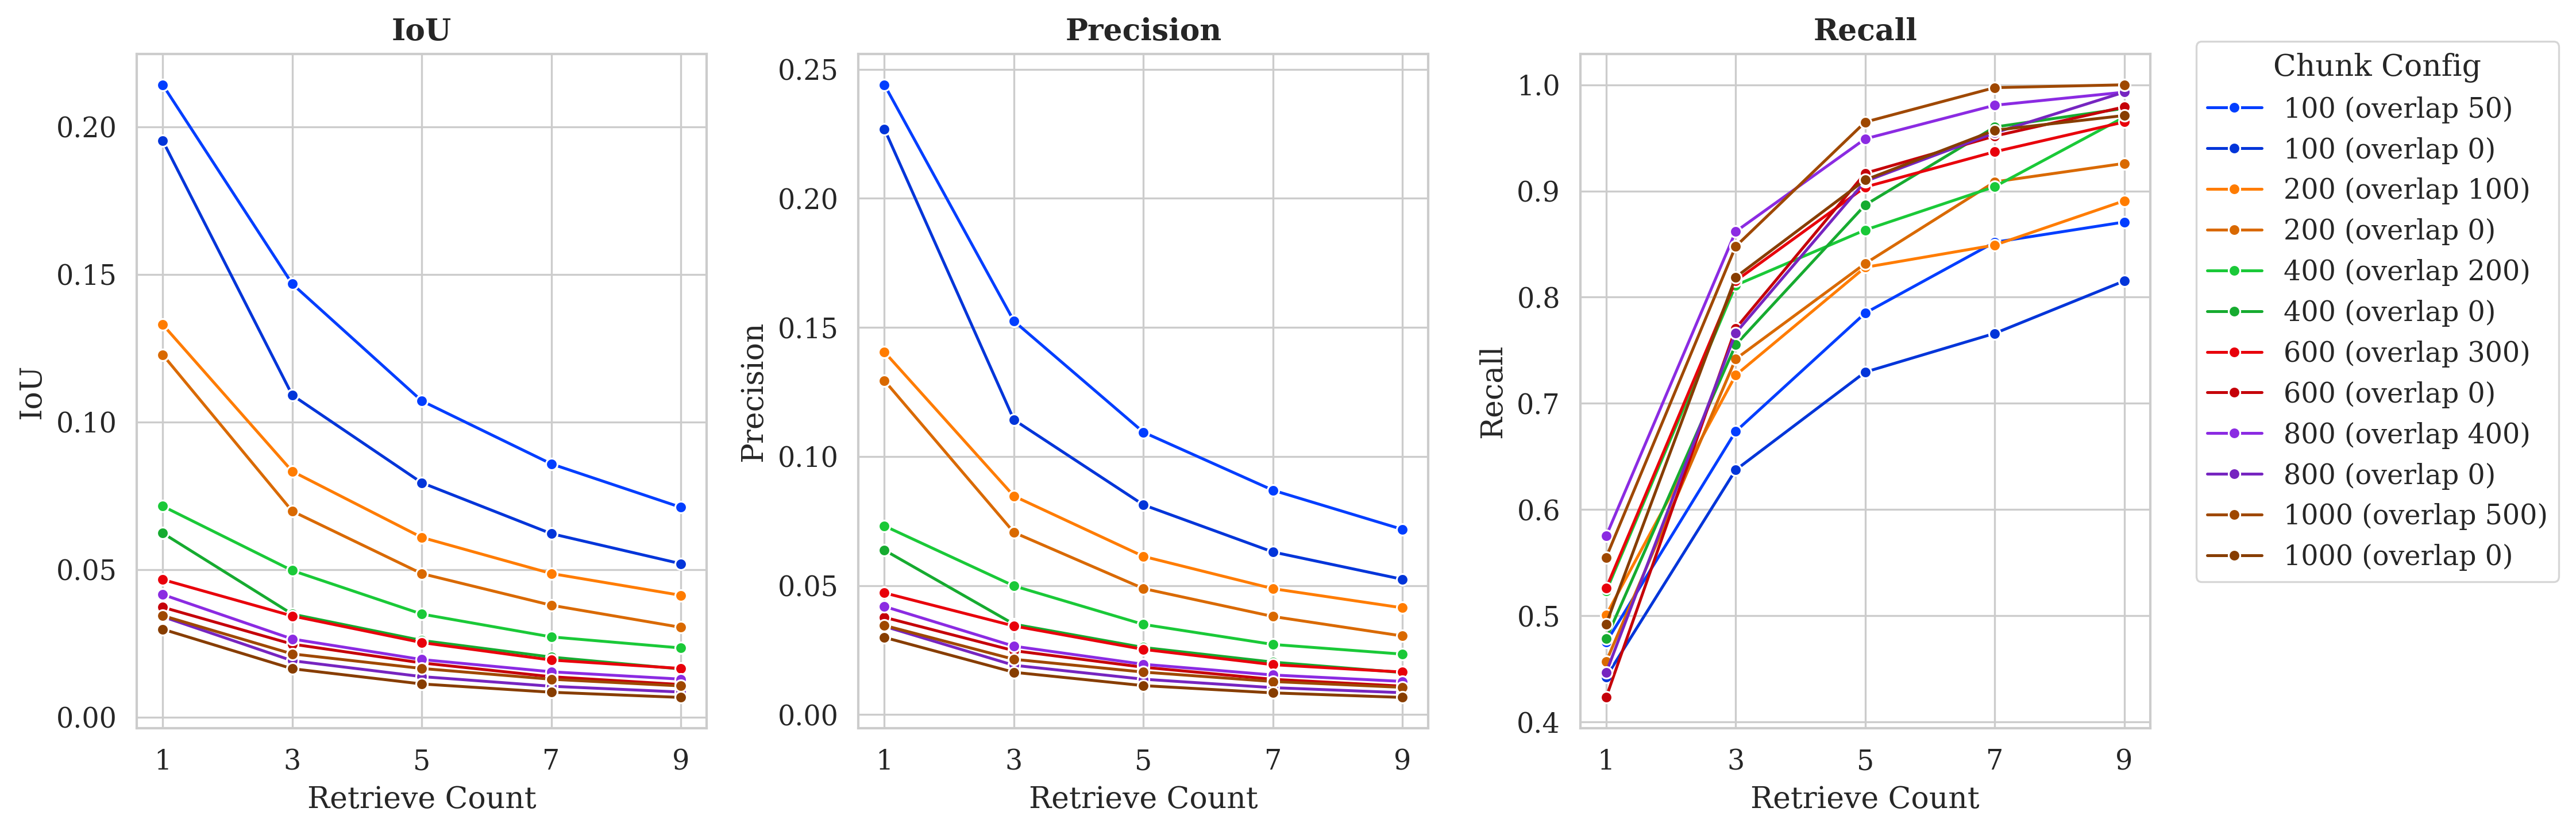

In [10]:
def plot_metrics_comparison(df, model_name, save_path):
    # Filter data for the specific model and corpus
    df_filtered = df[
        (df["embedding_function"] == model_name) & 
        (df["corpus"] == "wikitexts")
    ].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Add config column for plotting
    df_filtered.loc[:, "config"] = df_filtered["chunk_size"].astype(str) + " (overlap " + df_filtered["chunk_overlap"].astype(str) + ")"

    # Same base color but different shades for same chunk sizes
    unique_sizes = sorted(df_filtered["chunk_size"].unique())
    base_colors = sns.color_palette("bright", n_colors=len(unique_sizes))
    palette = {}
    for i, size in enumerate(unique_sizes):
        size_configs = df_filtered[df_filtered["chunk_size"] == size]["config"].unique()
        # Create shades of the base color
        shades = [base_colors[i]] * len(size_configs)
        if len(size_configs) > 1:
            shades[1] = tuple(x * 0.85 for x in base_colors[i])  # slightly darker shade
        palette.update(dict(zip(size_configs, shades)))

    fig, axes = plt.subplots(1, 3, figsize=FIGSIZE_L, dpi=DPI, sharex=True)
    metric_list = [("iou", "IoU"), ("precision", "Precision"), ("recall", "Recall")]

    # Data for the x-ticks
    retrieve_counts = sorted(df_filtered["retrieve_count"].unique())

    for ax, (metric, title) in zip(axes, metric_list):
        sns.lineplot(
            data=df_filtered,
            x="retrieve_count",
            y=metric,
            hue="config",
            marker="o",
            ax=ax,
            palette=palette,
        )
        ax.set_title(title, fontweight='semibold')
        ax.set_xlabel("Retrieve Count", fontweight='medium')
        ax.set_ylabel(title, fontweight='medium')
        ax.set_xticks(retrieve_counts)  # explicit ticks
        ax.legend_.remove()

    # Single legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels, title="Chunk Config", bbox_to_anchor=(0.85, 0.95), loc="upper left"
    )
    plt.tight_layout(rect=[0, 0, 0.85, 1])

    plt.savefig(str(save_path), bbox_inches="tight", dpi=DPI)
    plt.show()

# Read the CSV data from file
df = pd.read_csv("data/results.csv")

# Plot for all-MiniLM-L6-v2
plot_metrics_comparison(
    df,
    "all-MiniLM-L6-v2", 
    FIGURES_PATH / "metrics_comparison_all-MiniLM-L6-v2.png"
)

# Plot for multi-qa-mpnet-base-dot-v1
plot_metrics_comparison(
    df,
    "multi-qa-mpnet-base-dot-v1",
    FIGURES_PATH / "metrics_comparison_multi-qa-mpnet-base-dot-v1.png"
)